In [1]:
%matplotlib inline

import functools
from itertools import izip
import os
import datetime

from IPython.core.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy.stats
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from clipper.src import CLIP_analysis
from gscripts import qtools
from gscripts.encode import encode_helpers
from gscripts.general import dataviz
from gscripts.rnaseq import splicing_map

tqdm.pandas(desc="Progress")
sns.set_style("ticks")
img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2/"

xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))
xfmt_int = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(float(x) / 1000000), ','))


In [2]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

matplotlib.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [3]:
input_norm_dir = "/projects/ps-yeolab3/encode/analysis/Eric_Input_Norm/"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
frip_out_dir = "/home/gpratt/projects/encode/analysis/frip_calculations/"

downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

In [4]:
merged_data = encode_helpers.get_merged_data()

print len(merged_data[merged_data.submitted]) / 2

#Filter out anything sequenced after 16/7/18
merged_data = merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]
#Filter out any data we are planning on submitting, but haven't yet submitted
merged_data = merged_data[merged_data.annotation != "Submit"]

181


In [5]:
len(merged_data[merged_data.submitted]) / 2, len(merged_data)

(181, 498)

In [6]:
#Get all the counts
counts_list = pd.read_csv("downsample_counts_full_v4.csv", dtype={"RBP_ID": str, "bio_rep": str, "tech_rep": str},
                         index_col=["RBP_ID", "RBP", "bio_rep", "tech_rep", "fraction"])
counts_list = counts_list.xs(1.0, level="fraction").groupby(level=['RBP_ID', "RBP", "bio_rep"]).sum()
counts_list.index.rename(["uID", "RBP", "rep"], inplace=True)
counts_list.index = counts_list.index.droplevel("RBP")

counts_list['rep'] = ["rep1" if rep == 1 else "rep2" for rep in counts_list.index.get_level_values(level="rep")]
counts_list.index = counts_list.index.droplevel("rep")
counts_list = counts_list.set_index("rep", append=True)


In [7]:
merged_data = merged_data.reset_index(['Cell line', 'RBP'])

merged_data = pd.merge(merged_data, counts_list,
        left_index=True, right_index=True, how="left")

merged_data = merged_data.set_index(["RBP", "Cell line"], append=True)
merged_data = merged_data.reorder_levels(['uID','RBP', 'Cell line','rep'])

In [8]:
print "number of datasets without reads merged"
print len(merged_data[merged_data.unique.isnull()])

number of datasets without reads merged
0


# Merge regular counts (non-repmapped counts)


In [9]:
final_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_master_qc.csv")
final_qc_frame = final_qc_frame.fillna("")
final_qc_frame['Reads Written Round 2'] = final_qc_frame['Reads Written Round 2'].astype(int)
final_qc_frame = final_qc_frame.set_index(keys=["rbp", "encode_id", "rep", "cell_type", "full_name", "barcode"])
filtered_final_qc_frame = final_qc_frame[[ "Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Uniquely mapped reads %", 'Number of reads mapped to too many loci',
                                          '% of reads unmapped: too short', '% of reads mapped to too many loci', "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks", "Reads Written Round 2"]]

grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
grouped_final_qc_frame = grouped_final_qc_frame.dropna()
grouped_final_qc_frame['full_name'] = grouped_final_qc_frame.index.get_level_values(level="full_name")


In [10]:
#Make sure we can join input counts
fn_label_map = pd.read_table("/home/gpratt/projects/encode/scripts/encode_GRCh38_v1.txt", header=None,
              names=['fn', 'species', 'label', 'foo', 'bar', 'baz', 'biz'])
fn_label_map['fn_basename'] = fn_label_map.fn.apply(lambda x: os.path.basename(x.split(";")[0]).split(".")[0])
fn_label_map['label'] = fn_label_map.label.apply(lambda x: "_".join(x.split("_")[:-1]))

#Need to set the full name of the inputs to the actual name of the file, sadly I'm going to do this badly
inputs = grouped_final_qc_frame.xs("INPUT", level="rep")    
inputs = pd.merge(inputs, fn_label_map,
         left_on="full_name", right_on="label")

In [11]:
new_full_name = []
for name, row in grouped_final_qc_frame.iterrows():
    #print name, row
    name = inputs[inputs.label == row.full_name]
    if len(name) == 1:
        new_full_name.append(name.iloc[0].fn_basename)
    elif len(name) == 0:
        new_full_name.append(row.full_name)
    else:
        new_full_name.append(np.nan)
        print "error", row.full_name
grouped_final_qc_frame['full_file_name'] = new_full_name

error LNG8-M_INPUT_A04F05
error LNG8-S_INPUT_C01D08
error LNG12-N_INPUT_A04F05
error LNG10-M_INPUT_A04F05
error LNG10-S_INPUT_C01D08
error LNG11-M_INPUT_A04F05
error LNG11-S_INPUT_C01D08
error LNG9-M_INPUT_A04F05
error LNG9-S_INPUT_C01D08


In [12]:
merged_data['full_name'] = merged_data.CLIP.apply(lambda x: "_".join(os.path.basename(x).split("_")[:-1]))
merged_data = merged_data.reset_index()

merged_data = pd.merge(merged_data, grouped_final_qc_frame, 
               left_on="full_name", right_on="full_name", 
               how="left")

# Get Input Reads

In [13]:
input_names = grouped_final_qc_frame.set_index("full_file_name")
merged_data['input_file_name'] = merged_data.INPUT.apply(lambda x: os.path.basename(x).split(".")[0])
merged_data['input_usable'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['Usable Reads'])
merged_data['input_name'] = merged_data['input_file_name'].apply(lambda x: input_names.ix[x]['full_name'])

# Get Erics rmduped input reads

In [14]:
eric_reads = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/ENCODE_20170429_newannotations_FINAL.readnumbers.csv",
             names=["uID", "rep", "full_name", "same", "input_reads_name", "input_reads", "usable_name", "usable", 
              "unique_genome_nonrep_name", "unique_genome_nonrep"])
eric_reads = eric_reads.drop(["usable_name", "unique_genome_nonrep_name", "input_reads_name", "same"],axis=1)
eric_reads['uid'] = eric_reads.full_name.apply(lambda x: "_".join(x.split("_")[:-1]))
eric_reads = eric_reads.set_index("uid")


merged_data['family_map_input_usable'] = merged_data['input_name'].apply(lambda x: eric_reads.ix[x]['input_reads'])

# Update low read number based on family mapping + fscore trick

In [15]:
under_sequenced_data = merged_data[merged_data['Usable Reads'] < 1000000]
under_sequenced_data = under_sequenced_data.copy()

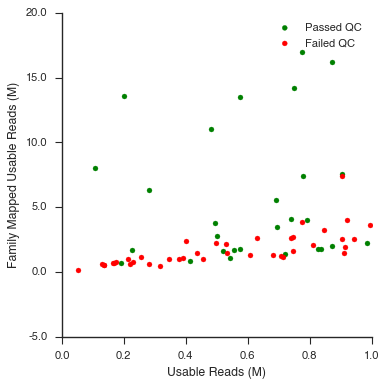

In [16]:
num_rows = 1 
num_cols = 1 
xfmt = matplotlib.ticker.FuncFormatter(lambda x, p: format(float(x) / 1000000, ','))

with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.scatter(under_sequenced_data[under_sequenced_data.generally_submittable]['Usable Reads'], 
               under_sequenced_data[under_sequenced_data.generally_submittable].unique, color='g', label="Passed QC")
    ax.scatter(under_sequenced_data[~under_sequenced_data.generally_submittable]['Usable Reads'],
               under_sequenced_data[~under_sequenced_data.generally_submittable].unique, color='r', label="Failed QC")
    ax.xaxis.set_major_formatter(xfmt)
    ax.yaxis.set_major_formatter(xfmt)
    ax.legend()
    ax.set_xlabel("Usable Reads (M)")
    ax.set_ylabel("Family Mapped Usable Reads (M)")
    sns.despine(ax=ax)
    ax.set_xlim(0,1000000)

In [17]:
true_positive_array, false_positive_array, threshold_array, best_threshold = encode_helpers.get_best_f_score(threshold_col="unique", 
                                                                                              true_clasification_col="generally_submittable", 
                                                                                              explore_range=np.arange(under_sequenced_data.unique.min(), under_sequenced_data.unique.max(), 10000),
                                                                                              df=under_sequenced_data)

0.705882352941
1487488.0


In [18]:
best_threshold

1487488.0

In [19]:
tp = under_sequenced_data[(under_sequenced_data.unique > best_threshold) & under_sequenced_data.generally_submittable]
fp = under_sequenced_data[(under_sequenced_data.unique > best_threshold) & ~under_sequenced_data.generally_submittable]
fn = under_sequenced_data[(under_sequenced_data.unique < best_threshold) & under_sequenced_data.generally_submittable]

In [20]:
print "false positives",  " ".join(set((fp.uID + "_" + fp.RBP).values))
print "false negatives", " ".join(set((fn.uID + "_" + fn.RBP).values))

false positives 328_TRIP6 674_NAA15 691_DAZAP1 255_EIF4A3 692_PCBP1 374_APOBEC3C 591_RBM17 266_FKBP4 327_RBM34 646_EIF3G 264_PRPF6 512_NELFE 673_DNAJC21
false negatives 262_SLBP 506_SF3B1 617_TBRG4


# Explanations for False Negatives

1. 262_SLBP -- known crazy rep thing
1. 506_SF3B1 -- very specific only binds U2/U11
1. 617_TBRG4 -- don't have a good reason, just slightly below threshold

In [21]:
encode_helpers.confusion_numbers(best_threshold, threshold_col="unique", 
                 true_clasification_col="generally_submittable",  df=under_sequenced_data)

(24.0, 16.0, 4.0, 24.0)

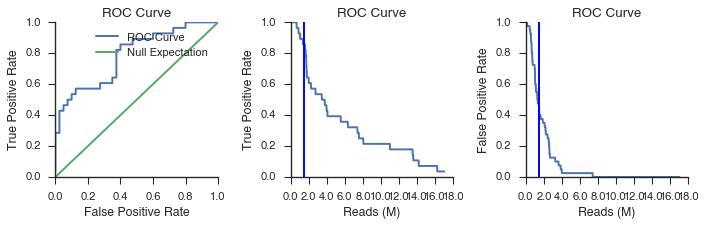

In [22]:
num_rows = 1
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "low_usable_reads.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,3,1)
    ax.plot(false_positive_array, true_positive_array, label="ROC Curve")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.plot([0,1], [0,1], label="Null Expectation") 
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")
    ax.legend()

    ax = fig.add_subplot(1,3,2)
    ax.plot(threshold_array, true_positive_array)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("Reads (M)")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")
    ax.xaxis.set_major_formatter(xfmt)

    ax.axvline(best_threshold)
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(threshold_array, false_positive_array)
    ax.set_ylabel("False Positive Rate")
    ax.set_xlabel("Reads (M)")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")
    ax.axvline(best_threshold)    
    ax.xaxis.set_major_formatter(xfmt)



In [23]:
background = sns.color_palette("Blues")[1]
foreground = sns.color_palette("Blues")[-1]

In [24]:
def assign_rep(item):
    if item == "01":
        return "rep1"
    elif item == "02":
        return "rep2"
    elif item == "INPUT":
        return "INPUT"
    else:
        print item
        return item

In [25]:
tp = merged_data[(merged_data.unique > best_threshold) & merged_data.generally_submittable]
fp = merged_data[(merged_data.unique > best_threshold) & ~merged_data.generally_submittable]
fn = merged_data[(merged_data.unique < best_threshold) & merged_data.generally_submittable]

In [26]:
arbitray_threshold = 1500000

In [27]:
merged_data.ix[((merged_data.unique < arbitray_threshold) & merged_data.generally_submittable), 'Read Level Filtering'] = "False Negative"
merged_data.ix[~((merged_data.unique < arbitray_threshold) & merged_data.generally_submittable), 'Read Level Filtering'] = "Other Classifications"
merged_data['log10_unique'] = merged_data.unique.apply(np.log10)

In [28]:
merged_data['group'] = "All Experiments"
merged_data['generally_submittable_str'] = ["Submitted" if submitted else "Not Submitted" for submitted in merged_data.generally_submittable] 

In [29]:
fn = merged_data[merged_data['Read Level Filtering'] == "False Negative"]

#Color by submitted / not submitted 
Could plot two different plots

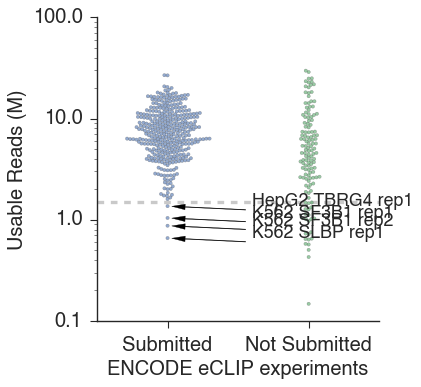

In [30]:
num_rows = 1 
num_cols = 1 
xloc = .6
with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads_presentation.svg"), figsize=(5 * num_cols,5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])

    sns.swarmplot(y="unique", x='generally_submittable_str', data=merged_data, 
                  alpha=.6, size=3, linewidth=.3, ax=ax, order=['Submitted', 'Not Submitted'])
    ax.axhline(best_threshold, color=".7", linewidth=3, linestyle="--", alpha=.7)
    ax.yaxis.set_major_formatter(xfmt)

    for x, (name, row) in enumerate(fn.iterrows()):
        name = row['Cell line'] + " " +  row.RBP + " " + row.rep
        yloc = row['unique']
        #xloc = xloc * -1
        ax.annotate(name, xy=(0, yloc), xytext=((xloc, yloc)),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5), fontsize=16
                   )

    ax.set_ylabel("Usable Reads (M)", fontsize=18)
    ax.set_xlabel("ENCODE eCLIP experiments", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(18) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

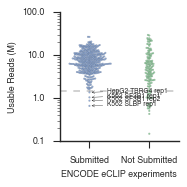

In [31]:
num_rows = 1 
num_cols = 1 
xloc = .3
with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)

    ax.set_yscale("log", basey=10, subsy=[2, 3, 4, 5, 6, 7, 8, 9])
    
    sns.swarmplot(y="unique", x='generally_submittable_str', data=merged_data, 
                  alpha=.6, size=1.7, linewidth=.1, ax=ax, order=['Submitted', 'Not Submitted'])
    ax.axhline(best_threshold, color=".7", linewidth=1.5, linestyle="--", alpha=.7)
    ax.yaxis.set_major_formatter(xfmt)

    for x, (name, row) in enumerate(fn.iterrows()):
        name = row['Cell line'] + " " +  row.RBP + " " + row.rep
        yloc = row['unique']
        #xloc = xloc * -1
        ax.annotate(name, xy=(0, yloc), xytext=((xloc, yloc)),
                    arrowprops=dict(facecolor='black',
                                    #shrink=0.05, 
                                    #width=.5, 
                                    #headwidth=2,
                                   arrowstyle="->"
                                   ), fontsize=6
                   )

    ax.set_ylabel("Usable Reads (M)", fontsize=8)
    ax.set_xlabel("ENCODE eCLIP experiments", fontsize=8)
    [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

In [32]:
#Data that passes minimum read threshold requierments
print "before removing low read counts", len(merged_data)

#I'm keep
merged_data = merged_data[(merged_data.unique >= arbitray_threshold) | merged_data.submitted]
#Len after filtering for min reads
print "after removing low read counts", len(merged_data)

before removing low read counts 498
after removing low read counts 474
